In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

(heating-rate-profile)=

# Heating rate profiles

In {ref}`heating-rate` we showed that the heating rate $Q_r$ (K/s) for a particular height in
the atmosphere was defined by:

$$
\begin{aligned}
\rho c_p \Delta z \frac{dT}{dt} &= \Delta E_n\\
Q_r = \frac{dT}{dt} &= \frac{1}{\rho c_p} \frac{\Delta E_n}{\Delta z} = \frac{1}{\rho c_p} \frac{dE_n}{dz}
\end{aligned}
$$

where $E_n$ was the net flux integrated over all wavelengths (positive downwards), and $\Delta E_n$ is
the net downward flux $(E_{ntop} - E_{nbot})$ across a layer of thickness $\Delta z$.

In this notebook we use the hydrostatic equation  from {ref}`hydro` and the flux equation
from {ref}`flux_schwartzchild` to find dT/dz as a function of height for an atmosphere with
containing an absorbing gas with a mixing ratio of $r_gas=0.01$ kg/kg and a mass absorption coefficient
averaged across all longwave wavelengths of $k=0.01$   $m^2/kg$.

## Integrate the atmospheric pressure, temperature and density

Recall equation {mat:numref}`hydro`:

$$
dp = -\rho g dz
$$

for a hydrostatic atmosphere, if we assume that dT/dz is constant with height, we can
build up an atmosphere one level at a time, but starting with know $p$, $\rho$ and $T$ at the
surface and using the values of $dT/dz$, $dp/dz$  to find $T$ and $p$ at the next level.  Once
we have those, we can use the ideal gas law to find the density $\rho$ and move up.

This is done in the cell below.

In [2]:
def hydrostat(T_surf,p_surf,dT_dz,delta_z,num_levels):
    """
       build a hydrostatic atmosphere by integrating the hydrostatic equation from the surface,
       using num_levels of constant thickness delta_z

       Parameters
       ----------

       T_surf: float
            surface temperature in K
       p_surf: float
            surface pressure in Pa
       dT_dz: ndarray
             rate of temperature change with height in K/m
       delta_z: float
             layer thickness in m
       num_levels: float
             number of levels in the atmosphere

       Returns
       -------

       Temp, press, rho, height: tuple of ndarrays of length num_levels
          where the surface is level 0, and each index i larger than 0
          is located at the height corresponding to the top of a particular layer,
          so that values at the top of the atmosphere are given by index
          numlevels - 1

          Temp (K) , press (Pa), rho (kg/m^3), height (m) for each layer
    """
    Rd=287. #J/kg/K  -- gas constant for dry air
    g=9.8  #m/s^2
    Temp=np.empty([num_levels])
    press=np.empty_like(Temp)
    rho=np.empty_like(Temp)
    height=np.empty_like(Temp)
    #
    # level 0 sits directly above the surface, so start
    # with pressure, temp of air equal to ground temp, press
    # and get density from equaiton of state
    #
    press[0]=p_surf
    Temp[0]=T_surf
    rho[0]=p_surf/(Rd*T_surf)
    height[0]=0
    num_layers=num_levels - 1
    #now march up the atmosphere a level at a time
    # finding the values at the top of each layer
    for i in range(num_layers):
        delP= -rho[i]*g*delta_z
        height[i+1] = height[i] + delta_z
        Temp[i+1] = Temp[i] + dT_dz[i]*delta_z
        press[i+1]= press[i] + delP
        rho[i+1]=press[i+1]/(Rd*Temp[i+1])
    return (Temp,press,rho,height)

## Next we can find the optical depth

If we have the air density $\rho$, the mixing ratio $r_{mix}$ asnd  the absorption coefficient $k$ from Stull Chapter 2
section 2.3.6 we can find the optical depth in the layer:

$$
\tau = \rho r_{mix} k \Delta z
$$

where $\Delta z$ is the layer thickness.  That's done in the next cell.

In [3]:
def find_tau(r_gas,k,rho,height):
    """
       Parameters
       ----------

       r_gas: float
           gas mixing ratio in kg/kg
       k: float
           mass absorption coefficient in kg/m^2
       rho: ndarray
           vector of air densities in kg/m^3 for each layer
       height: ndarray
        corresponding level heights in m

       Returns
       -------

          tau: ndarray
             vertical optical depths of each level, starting from 0 at the surface
    """
    tau=np.empty_like(rho)
    tau[0]=0
    num_levels=len(rho)
    num_layers=num_levels - 1
    for index in range(num_layers):
        delta_z=height[index+1] - height[index]
        delta_tau=r_gas*rho[index]*k*delta_z
        tau[index+1]=tau[index] + delta_tau
    return tau

## Flux with height

Note the factor of 1.666 below that multiplies the optical depth in
the transmission -- this is the flux diffusivity approximation.  The function below
solves for the upward and downward fluxes one layer at at time by calculating
the transmitted flux arriving from the bottom or the top of each layer, and the
emitted flux that the layer is sending to the next layer above or below using the equation given in
{math:numref}`layer_flux`. This is the
"two stream approximation" mentioned in {ref}`two-stream-approx`

Assumption:  layers are thin enough so that it is safe to assume constant values
within each layer

In [4]:
def fluxes(tau,Temp,height,T_surf):
    """
    given properties at each level return the upward and downward
    total flux at each level assuming no downward longwave flux at the top
    of the atmosphere, and a surface flux of sigma*T_surf**4.

    Parameters
    -----------

    tau, Temp, height:  ndarray of length tot_levels
        total optical depth (from surface), temperature (K) and height (m)
        at each level

    Returns
    -------

    up_flux, down_flux: ndarrays
       upward and downward flux of each level (W/m^2), all positive

    """
    sigma=5.67e-8 #W/m^2/K^4
    Esolar=240.  #solar flux in W/m^2
    up_flux=np.empty_like(height)
    down_flux=np.empty_like(height)
    sfc_flux=sigma*T_surf**4.
    up_flux[0]=sfc_flux
    #print(f"{sfc_flux=}")
    tot_levs=len(tau)
    for index in np.arange(1,tot_levs):
        upper_lev=index
        lower_lev=index - 1
        del_tau=tau[upper_lev] - tau[lower_lev]
        trans=np.exp(-del_tau)
        emiss=1 - trans
        layer_flux=sigma*Temp[lower_lev]**4.*emiss
        #
        # find the flux at the next level
        #
        up_flux[upper_lev]=trans*up_flux[lower_lev] + layer_flux
    #
    # start at the top of the atmosphere
    # with zero downwelling flux
    #
    down_flux[tot_levs-1]=0
    #
    # go down a level at a time, adding up the fluxes
    #
    for index in np.arange(1,tot_levs):
        upper_lev=tot_levs - index
        lower_lev=tot_levs - index -1
        del_tau=tau[upper_lev] - tau[lower_lev]
        trans=np.exp(-1.666*del_tau)
        emiss=1 - trans
        layer_flux=sigma*Temp[upper_lev]**4.*emiss
        down_flux[lower_lev]=down_flux[upper_lev]*trans + layer_flux
    return (up_flux,down_flux)

In [5]:
def heating_rate(net_down,height,rho):
    """
    given the net flux at each level (downward positive) and the
    height, and density of the atmosphere at each level, return
    the rate of change of temperature in each layer between two levels

    Parameters
    ----------

    net_down: ndarray
       positive downward net flux (W/m^2) at each level

    height: ndarray
       vertical location of each level (m)

    rho: ndarray
       density (kg/m^3) at each level

    Returns
    -------

    dT_dz: ndarray  -- length nlevels -1
       vector of temperature gradients across each layer (K/m)


    """

    cpd=1004.
    #
    # find the flux divergence across the layer
    # by differencing the levels.  Assume the layer density is constant
    # and equal to the average of the densities at the top and bottom levels
    #
    rho_mid=(rho[1:] + rho[:-1])/2.
    dEn_dz= np.diff(net_down)/np.diff(height)
    dT_dz=dEn_dz/(rho_mid*cpd)
    #print(f"{dT_dz*3600=}")
    return dT_dz

In [6]:
def main():
    """
    find the heating rate (K/km) for a hydrostatic
    atmosphere with a constant decrease of temperature with heigt
    """

    #
    # use 1500 1 m thick layers from 0 to 15 km
    #
    r_gas=0.01  #kg/kg
    k=0.002  #m^2/kg
    T_surf=300 #K
    p_surf=100.e3 #Pa
    delta_z=100  #m
    num_levels=150
    dT_dz = np.ones([num_levels])*(-7.e-3)
    #
    #
    #
    Temp,press,rho,height=hydrostat(T_surf,p_surf,dT_dz,delta_z,num_levels)
    tau=find_tau(r_gas,k,rho,height)
    up,down=fluxes(tau,Temp,height,T_surf)
    net_down = down - up
    dT_dt=heating_rate(down - up,height,rho)

    fig,(axis1,axis2,axis3)=plt.subplots(1,3,figsize=(15,10))
    axis1.plot(up,height*0.001,'b-',lw=5,label='upward flux')
    axis1.plot(down,height*0.001,'g-',lw=5,label='downward flux')
    axis1.set_title('upward and downward fluxes')
    axis1.set_xlabel('flux $(W\,m^{-2}$')
    axis1.set_ylabel('height (km)')
    axis1.legend(numpoints=1,loc='best')
    axis1.grid(True)


    axis2.plot(net_down,height*0.001,'b-',lw=5)
    axis2.set_title('net downward flux')
    axis2.set_xlabel('net downward flux $(W\,m^{-2})$')
    axis2.set_ylabel('height (km)')
    axis2.grid(True)


    dT_dt=dT_dt*3600.
    mid_height=(height[1:] + height[:-1])/2.
    axis3.plot(dT_dt,mid_height*0.001,'b-',lw=5)
    axis3.set_title('heating rate')
    axis3.set_xlabel('heating rate in K/hr')
    axis3.set_ylabel('height (km)')
    axis3.grid(True)

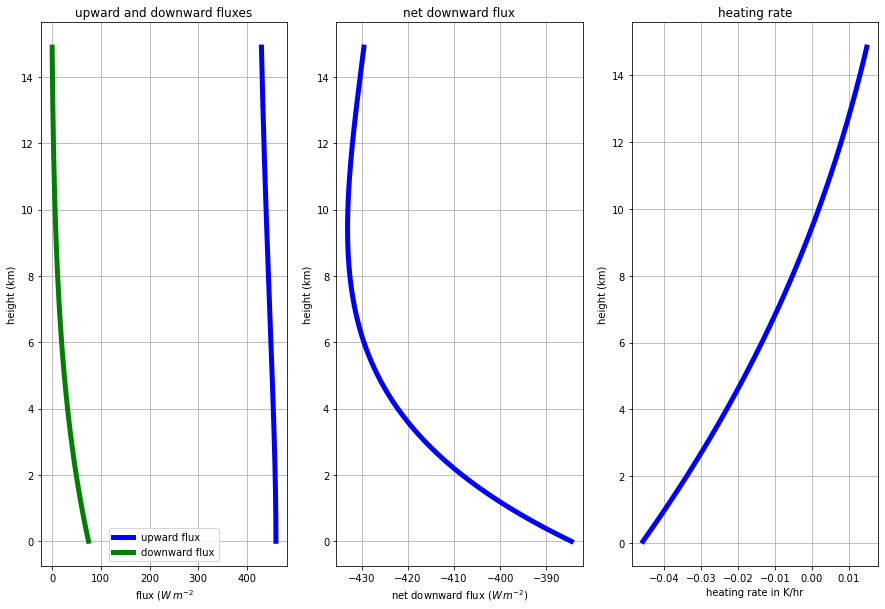

In [7]:
main()

In [8]:
def evolve():
    """
    find the heating rate (K/km) for a hydrostatic
    atmosphere with a constant decrease of temperature with heigt
    """

    #
    # use 1500 1 m thick layers from 0 to 15 km
    #
    r_gas=0.01  #kg/kg
    sigma=5.67e-8
    k=0.003  #m^2/kg
    T_surf=300 #K
    p_surf=100.e3 #Pa
    delta_z=100  #m
    delta_t = 3600.
    num_levels=150
    num_timesteps=4000
    E_solar = 240.
    dT_dz = np.ones([num_levels])*(-7.e-3)
    #
    #
    #
    Temp,press,rho,height=hydrostat(T_surf,p_surf,dT_dz,delta_z,num_levels)
    keep_prof=[Temp]
    for time_index in range(num_timesteps):
        tau=find_tau(r_gas,k,rho,height)
        up,down=fluxes(tau,Temp,height,T_surf)
        net_down = down - up
        dT_dt=heating_rate(net_down,height,rho)
        Temp[:-1] = Temp[:-1] + dT_dt*delta_t
        Temp[-1]=Temp[-2]
        dT_dz = np.diff(Temp)/delta_z
        keep_prof.append((Temp,up,down))
        sfc_flux = down[0] + E_solar
        T_surf = (sfc_flux/sigma)**0.25
        print(T_surf)
        Temp,press,rho,height=hydrostat(T_surf,p_surf,dT_dz,delta_z,num_levels)
    return keep_prof,height



279.5146676053605
274.16999700002407
272.9058602604911
272.6179916197014
272.55633938506935
272.5467142888929
272.54903552723425
272.5540984837488
272.55978984209554
272.5656243327612
272.571490499432
272.5773627350938
272.5832351535168
272.58910639973567
272.594976160199
272.6008443607628
272.6067109823347
272.6125760184855
272.61843946570104
272.62430132113934
272.6301615821145
272.63602024597833
272.64187731009264
272.6477327718232
272.65358662853816
272.65943887760784
272.66528951640447
272.6711385423023
272.6769859526777
272.682831744909
272.68867591637644
272.6945184644625
272.7003593865515
272.7061986800299
272.71203634228624
272.71787237071095
272.7237067626967
272.72953951563807
272.73537062693174
272.7412000939766
272.7470279141734
272.75285408492505
272.7586786036367
272.7645014677154
272.7703226745703
272.77614222161276
272.7819601062562
272.78777632591607
272.79359087801015
272.7994037599582
272.80521496918203
272.8110245031057
272.8168323591555
272.8226385347596
272.82844


273.50085443176465
273.50644096415743
273.5120255223295
273.51760810400924
273.5231887069276
273.52876732881856
273.5343439674185
273.53991862046695
273.5454912857059
273.5510619608803
273.55663064373795
273.5621973320292
273.5677620235073
273.57332471592844
273.5788854070513
273.5844440946377
273.59000077645203
273.5955554502616
273.6011081138365
273.6066587649497
273.6122074013769
273.6177540208967
273.62329862129053
273.6288412003426
273.6343817558401
273.6399202855729
273.6454567873338
273.6509912589185
273.65652369812545
273.6620541027561
273.6675824706147
273.6731087995084
273.67863308724714
273.6841553316438
273.68967553051425
273.69519368167704
273.70070978295377
273.706223832169
273.71173582714994
273.71724576572694
273.72275364573323
273.72825946500484
273.73376322138074
273.73926491270305
273.7447645368165
273.75026209156886
273.75575757481096
273.7612509843965
273.7667423181821
273.7722315740273
273.77771874979464
273.78320384334967
273.7886868525607
273.79416777529934
273


274.37862676774023
274.38386588435884
274.38910269755894
274.3943372055676
274.39956940661517
274.4047992989355
274.41002688076566
274.41525215034625
274.4204751059211
274.4256957457376
274.4309140680463
274.4361300711013
274.44134375315986
274.446555112483
274.45176414733476
274.45697085598283
274.4621752366981
274.467377287755
274.4725770074315
274.47777439400846
274.4829694457707
274.48816216100624
274.49335253800643
274.49854057506604
274.50372627048347
274.5089096225604
274.5140906296018
274.51926928991634
274.5244456018159
274.5296195636158
274.534791173635
274.5399604301957
274.54512733162363
274.55029187624785
274.55545406240094
274.5606138884191
274.56577135264166
274.5709264534116
274.57607918907524
274.5812295579825
274.5863775584867
274.59152318894456
274.59666644771636
274.60180733316565
274.6069458436598
274.61208197756923
274.6172157332682
274.62234710913435
274.6274761035486
274.6326027148956
274.63772694156336
274.64284878194337
274.6479682344306
274.6530852974236
274


275.2010321353684
275.20587484062384
275.21071499958487
275.21555261105635
275.22038767384714
275.2252201867696
275.23005014863975
275.23487755827733
275.2397024145057
275.24452471615206
275.249344462047
275.2541616510252
275.2589762819246
275.26378835358713
275.2685978648583
275.2734048145873
275.2782092016271
275.2830110248341
275.2878102830686
275.2926069751947
275.2974011000799
275.30219265659565
275.30698164361684
275.3117680600223
275.31655190469445
275.3213331765193
275.3261118743867
275.3308879971902
275.3356615438269
275.34043251319775
275.3452009042074
275.349966715764
275.35472994677957
275.35949059616985
275.3642486628542
275.36900414575575
275.37375704380116
275.378507355921
275.3832550810494
275.38800021812426
275.3927427660872
275.39748272388357
275.40222009046227
275.406954864776
275.4116870457812
275.41641663243803
275.4211436237102
275.4258680185653
275.43058981597454
275.43530901491283
275.44002561435883
275.44473961329487
275.44945101070704
275.45415980558505
275.4


275.9604469054965
275.964858715576
275.9692678328368
275.9736742566904
275.97807798655185
275.9824790218399
275.98687736197695
275.99127300638906
275.995665954506
276.0000562057612
276.00444375959165
276.00882861543806
276.01321077274486
276.01759023095997
276.02196698953503
276.02634104792537
276.03071240559007
276.03508106199155
276.0394470165962
276.04381026887387
276.0481708182981
276.0525286643461
276.05688380649866
276.0612362442403
276.06558597705913
276.06993300444685
276.07427732589883
276.0786189409142
276.08295784899553
276.08729404964913
276.0916275423849
276.09595832671636
276.10028640216086
276.10461176823895
276.10893442447514
276.11325437039756
276.1175716055378
276.1218861294312
276.1261979416166
276.13050704163675
276.1348134290376
276.13911710336896
276.1434180641843
276.1477163110404
276.1520118434981
276.15630466112145
276.1605947634784
276.16488215014033
276.1691668206822
276.17344877468275
276.1777280117242
276.18200453139224
276.18627833327645
276.1905494169699


276.6437042028974
276.64767186739084
276.651636790411
276.65559897194447
276.659558411981
276.66351511051374
276.66746906753923
276.6714202830572
276.67536875707094
276.6793144895869
276.6832574806148
276.6871977301679
276.69113523826263
276.69507000491876
276.6990020301594
276.7029313140111
276.7068578565033
276.7107816576693
276.7147027175454
276.71862103617116
276.72253661358957
276.72644944984694
276.7303595449927
276.7342668990797
276.73817151216423
276.74207338430546
276.74597251556617
276.74986890601235
276.75376255571325
276.75765346474134
276.76154163317244
276.7654270610856
276.76930974856316
276.77318969569063
276.77706690255695
276.78094136925415
276.78481309587755
276.78868208252584
276.79254832930087
276.7964118363076
276.8002726036545
276.80413063145306
276.80798591981807
276.8118384688676
276.815688278723
276.81953534950856
276.8233796813521
276.82722127438456
276.83106012874003
276.8348962445559
276.83872962197285
276.8425602611344
276.84638816218774
276.8502133252829


277.2543203825224
277.2578432929364
277.26136350165666
277.264881009173
277.26839581597795
277.2719079225669
277.2754173294381
277.27892403709234
277.28242804603354
277.28592935676807
277.28942796980533
277.29292388565733
277.29641710483884
277.2999076278675
277.3033954552637
277.30688058755044
277.3103630252536
277.3138427689018
277.31731981902635
277.32079417616126
277.3242658408435
277.3277348136125
277.3312010950105
277.33466468558254
277.33812558587624
277.3415837964421
277.34503931783325
277.34849215060547
277.3519422953174
277.35538975253013
277.3588345228076
277.36227660671665
277.3657160048263
277.3691527177088
277.37258674593863
277.3760180900932
277.3794467507525
277.3828727284992
277.3862960239187
277.38971663759895
277.3931345701306
277.39654982210703
277.39996239412415
277.4033722867805
277.4067795006773
277.4101840364185
277.4135858946106
277.4169850758626
277.4203815807864
277.4237754099962
277.42716656410914
277.4305550437447
277.4339408495251
277.4373239820751
277.44


277.7902135766375
277.7933070343254
277.79639790332726
277.7994861845325
277.80257187883285
277.805654987122
277.80873551029606
277.8118134492529
277.81488880489263
277.81796157811755
277.8210317698319
277.8240993809421
277.82716441235664
277.8302268649861
277.8332867397431
277.8363440375423
277.83939875930065
277.8424509059368
277.84550047837183
277.84854747752865
277.8515919043323
277.8546337597097
277.8576730445902
277.86070975990475
277.86374390658665
277.866775485571
277.8698044977952
277.87283094419837
277.8758548257218
277.8788761433088
277.8818948979046
277.88491109045657
277.887924721914
277.8909357932281
277.8939443053522
277.8969502592416
277.89995365585344
277.902954496147
277.9059527810835
277.9089485116261
277.91194168873983
277.9149323133919
277.9179203865512
277.9209059091889
277.92388888227777
277.9268693067928
277.9298471837107
277.9328225140103
277.93579529867225
277.9387655386791
277.9417332350154
277.94469838866763
277.94766100062407
277.950621071875
277.953578603


278.2582681855048
278.2609552308967
278.26363985632497
278.26632206296574
278.26900185199656
278.2716792245963
278.2743541819453
278.2770267252252
278.2796968556192
278.2823645743117
278.28502988248863
278.28769278133734
278.29035327204645
278.29301135580596
278.2956670338072
278.29832030724305
278.30097117730764
278.3036196451964
278.30626571210627
278.30890937923533
278.3115506477831
278.3141895189506
278.3168259939401
278.319460073955
278.32209176020007
278.3247210538817
278.3273479562074
278.329972468386
278.3325945916277
278.3352143271439
278.33783167614735
278.3404466398522
278.3430592194737
278.34566941622853
278.3482772313347
278.3508826660114
278.35348572147905
278.35608639895946
278.3586846996758
278.3612806248522
278.36387417571433
278.366465353489
278.3690541594043
278.37164059468944
278.3742246605752
278.3768063582932
278.37938568907657
278.3819626541596
278.38453725477785
278.38710949216795
278.3896793675679
278.39224688221685
278.39481203735517
278.39737483422454
278.39


278.6605507605283
278.6628641916362
278.6651754074876
278.6674844094328
278.66979119882296
278.67209577701
278.6743981453466
278.676698305186
278.67899625788243
278.68129200479086
278.6835855472667
278.6858768866665
278.68816602434725
278.6904529616667
278.6927376999835
278.6950202406569
278.6973005850468
278.69957873451386
278.7018546904195
278.7041284541259
278.7064000269957
278.7086694103925
278.71093660568033
278.71320161422415
278.7154644373896
278.71772507654276
278.71998353305065
278.72223980828085
278.72449390360157
278.7267458203817
278.728995559991
278.7312431237995
278.7334885131783
278.73573172949887
278.7379727741334
278.74021164845476
278.7424483538364
278.74468289165253
278.74691526327786
278.74914547008785
278.7513735134585
278.75359939476635
278.75582311538875
278.7580446767036
278.76026408008937
278.7624813269252
278.7646964185907
278.7669093564662
278.7691201419327
278.77132877637166
278.7735352611651
278.77573959769575
278.7779417873469
278.78014183150236
278.78233


279.00541987788864
279.00739446618826
279.00936706396874
279.0113376726571
279.01330629368044
279.0152729284664
279.0172375784425
279.01920024503664
279.0211609296769
279.02311963379145
279.0250763588088
279.0270311061575
279.02898387726634
279.03093467356433
279.03288349648057
279.0348303474445
279.0367752278855
279.0387181392334
279.04065908291795
279.04259806036913
279.0445350730171
279.0464701222922
279.04840320962495
279.0503343364458
279.0522635041858
279.0541907142757
279.0561159681466
279.05803926722973
279.0599606129563
279.0618800067579
279.0637974500661
279.06571294431257
279.06762649092923
279.0695380913481
279.0714477470012
279.0733554593207
279.07526122973906
279.0771650596885
279.0790669506018
279.08096690391153
279.0828649210504
279.0847610034512
279.08665515254705
279.08854736977077
279.09043765655565
279.0923260143348
279.0942124445416
279.09609694860933
279.0979795279715
279.0998601840617
279.10173891831346
279.10361573216045
279.1054906270365
279.10736360437534
279


279.30201135983
279.303680400296
279.30534768358086
279.30701321110877
279.3086769843038
279.3103390045898
279.31199927339037
279.3136577921289
279.3153145622286
279.3169695851122
279.3186228622026
279.3202743949221
279.32192418469293
279.32357223293707
279.32521854107625
279.32686311053186
279.32850594272514
279.3301470390772
279.33178640100857
279.3334240299398
279.3350599272911
279.3366940944824
279.3383265329334
279.33995724406344
279.34158622929175
279.3432134900372
279.3448390277183
279.3464628437536
279.34808493956103
279.3497053165584
279.3513239761632
279.3529409197927
279.35455614886376
279.35616966479313
279.3577814689972
279.35939156289203
279.36099994789333
279.36260662541673
279.36421159687734
279.36581486369016
279.36741642726975
279.3690162890303
279.3706144503861
279.3722109127506
279.37380567753723
279.37539874615914
279.37699012002906
279.37857980055946
279.38016778916244
279.3817540872499
279.38333869623324
279.3849216175236
279.38650285253203
279.388082402669
279.


279.5518658878266
279.55326709621414
279.554666775201
279.55606492614925
279.5574615504204
279.5588566493753
279.56025022437456
279.56164227677806
279.5630328079452
279.564421819235
279.5658093120056
279.56719528761494
279.56857974742024
279.56996269277835
279.5713441250454
279.5727240455771
279.57410245572856
279.5754793568544
279.5768547503086
279.57822863744474
279.5796010196157
279.580971898174
279.5823412744715
279.5837091498595
279.58507552568875
279.58644040330944
279.58780378407124
279.5891656693233
279.5905260604141
279.5918849586917
279.5932423655035
279.5945982821964
279.5959527101167
279.5973056506101
279.59865710502186
279.6000070746966
279.60135556097833
279.6027025652105
279.6040480887362
279.6053921328976
279.60673469903645
279.6080757884941
279.6094154026111
279.61075354272754
279.61209021018277
279.61342540631574
279.6147591324648
279.61609138996766
279.6174221801615
279.61875150438283
279.62007936396765
279.62140576025143
279.6227306945688
279.62405416825413
279.625


279.7610192454609
279.76218873686224
279.76335691306383
279.7645237753263
279.76568932490954
279.76685356307274
279.7680164910743
279.76917811017205
279.770338421623
279.7714974266836
279.77265512660927
279.7738115226551
279.7749666160751
279.776120408123
279.7772729000514
279.7784240931124
279.77957398855744
279.78072258763706
279.7818698916012
279.783015901699
279.78416061917903
279.785304045289
279.7864461812759
279.78758702838616
279.7887265878653
279.7898648609582
279.79100184890893
279.79213755296104
279.79327197435725
279.79440511433944
279.7955369741489
279.79666755502615
279.79779685821103
279.7989248849425
279.800051636459
279.80117711399805
279.80230131879654
279.8034242520908
279.804545915116
279.805666309107
279.8067854352977
279.80790329492123
279.80901988921016
279.8101352193963
279.8112492867105
279.8123620923831
279.8134736376437
279.8145839237211
279.81569295184323
279.8168007232376
279.81790723913065
279.81901250074833
279.8201165093157
279.821219266057
279.82232077


279.93612554171136
279.93709565936956
279.9380646586395
279.9390325406576
279.93999930655934
279.94096495747954
279.941929494552
279.94289291891005
279.943855231686
279.9448164340113
279.94577652701685
279.9467355118325
279.94769338958747
279.9486501614101
279.9496058284281
279.95056039176814
279.95151385255605
279.9524662119171
279.9534174709758
279.95436763085553
279.95531669267916
279.9562646575687
279.9572115266451
279.9581573010289
279.95910198183964
279.96004557019614
279.96098806721625
279.9619294740171
279.96286979171515
279.96380902142596
279.96474716426417
279.9656842213438
279.966620193778
279.9675550826791
279.96848888915855
279.96942161432713
279.97035325929477
279.97128382517064
279.97221331306304
279.9731417240794
279.9740690593265
279.9749953199102
279.9759205069356
279.976844621507
279.97776766472776
279.97868963770077
279.97961054152773
279.9805303773098
279.98144914614716
279.9823668491392
279.9832834873847
279.9841990619814
279.98511357402646
279.9860270246159
279.


280.08027102758564
280.0810732805444
280.0818745896796
280.08267495599557
280.0834743804958
280.08427286418265
280.0850704080581
280.08586701312294
280.0866626803775
280.08745741082095
280.08825120545185
280.08904406526796
280.08983599126617
280.09062698444245
280.09141704579207
280.09220617630956
280.09299437698843
280.0937816488216
280.09456799280105
280.09535340991783
280.0961379011624
280.09692146752445
280.0977041099925
280.09848582955453
280.0992666271977
280.1000465039083
280.1008254606718
280.10160349847274
280.1023806182951
280.10315682112196
280.10393210793546
280.10470647971704
280.1054799374473
280.106252482106
280.10702411467213
280.10779483612384
280.1085646474385
280.10933354959263
280.110101543562
280.11086863032136
280.1116348108449
280.11240008610594
280.1131644570769
280.1139279247294
280.1146904900344
280.11545215396177
280.1162129174809
280.1169727815601
280.1177317471669
280.1184898152682
280.1192469868299
280.1200032628173
280.1207586441945
280.1215131319252
280


280.1979409166818
280.19860359441265
280.1992654795722
280.19992657303516
280.2005868756753
280.2012463883656
280.20190511197836
280.2025630473852
280.20322019545665
280.20387655706264
280.2045321330723
280.20518692435394
280.20584093177507
280.2064941562025
280.2071465985022
280.2077982595394
280.20844914017835
280.20909924128284
280.2097485637156
280.21039710833867
280.21104487601343
280.2116918676002
280.21233808395874
280.212983525948
280.2136281944262
280.2142720902505
280.21491521427754
280.21555756736313
280.2161991503623
280.2168399641293
280.2174800095175
280.2181192873795
280.21875779856737
280.21939554393214
280.2200325243241
280.2206687405928
280.22130419358706
280.22193888415484
280.22257281314336
280.2232059813991
280.2238383897676
280.22447003909383
280.22510093022186
280.22573106399506
280.22636044125596
280.2269890628463
280.22761692960717
280.2282440423787
280.2288704020004
280.2294960093109
280.23012086514814
280.23074497034924
280.23136832575045
280.23199093218756



280.2966352169699
280.2971790434048
280.2977222104017
280.2982647187103
280.2988065690797
280.2993477622583
280.29988829899355
280.30042818003227
280.3009674061206
280.301505978004
280.3020438964271
280.3025811621339
280.3031177758675
280.30365373837043
280.3041890503844
280.3047237126505
280.30525772590903
280.30579109089956
280.30632380836084
280.30685587903116
280.30738730364783
280.3079180829476
280.30844821766635
280.3089777085393
280.3095065563011
280.3100347616854
280.3105623254254
280.3110892482533
280.31161553090084
280.31214117409894
280.3126661785777
280.3131905450666
280.3137142742945
280.3142373669893
280.3147598238783
280.31528164568834
280.3158028331451
280.31632338697375
280.31684330789875
280.3173625966439
280.3178812539321
280.3183992804857
280.3189166770264
280.3194334442749
280.3199495829515
280.3204650937755
280.32097997746575
280.32149423474016
280.3220078663162
280.3225208729104
280.3230332552386
280.32354501401596
280.324056149957
280.3245666637755
280.32507655


280.37619019412745
280.37663702087696
280.37708329978574
280.37752903149163
280.37797421663174
280.3784188558425
280.3788629497597
280.37930649901847
280.3797495042533
280.38019196609804
280.3806338851859
280.3810752621492
280.38151609761996
280.3819563922294
280.3823961466081
280.3828353613859
280.38327403719194
280.383712174655
280.38414977440294
280.38458683706295
280.3850233632618
280.38545935362544
280.3858948087792
280.3863297293478
280.3867641159552
280.38719796922487
280.3876312897795
280.3880640782412
280.3884963352315
280.388928061371
280.3893592572801
280.3897899235781
280.390220060884
280.39064966981596
280.39107875099154
280.39150730502763
280.39193533254064
280.3923628341461
280.39278981045913
280.393216262094
280.3936421896644
280.3940675937834
280.39449247506354
280.39491683411654
280.3953406715535
280.39576398798516
280.39618678402115
280.39660906027075
280.3970308173427
280.39745205584484
280.3978727763846
280.39829297956857
280.39871266600284
280.3991318362928
280.3


280.44185752622246
280.442223475042
280.44258897108296
280.4429540148826
280.44331860697775
280.4436827479046
280.4440464381986
280.44440967839483
280.4447724690278
280.4451348106312
280.44549670373834
280.445858148882
280.4462191465942
280.4465796974066
280.4469398018501
280.44729946045504
280.4476586737512
280.44801744226805
280.448375766534
280.44873364707735
280.4490910844255
280.44944807910537
280.4498046316434
280.45016074256546
280.4505164123966
280.45087164166165
280.4512264308847
280.45158078058915
280.45193469129805
280.4522881635338
280.4526411978182
280.4529937946724
280.4533459546172
280.45369767817266
280.4540489658585
280.45439981819345
280.4547502356961
280.4551002188843
280.45544976827523
280.45579888438573
280.4561475677319
280.45649581882935
280.45684363819316
280.4571910263378
280.45753798377723
280.4578845110247
280.458230608593
280.4585762769945
280.4589215167408
280.45926632834306
280.4596107123118
280.459954669157
280.46029819938815
280.4606413035141
280.460983


280.4961926984558
280.4964911684514
280.4967892663775
280.4970869926826
280.4973843478149
280.4976813322217
280.49797794635015
280.4982741906467
280.4985700655575
280.498865571528
280.4991607090031
280.49945547842754
280.4997498802453
280.50004391489983
280.5003375828342
280.50063088449104
280.50092382031227
280.50121639073944
280.5015085962136
280.5018004371754
280.50209191406486
280.50238302732146
280.50267377738436
280.50296416469206
280.5032541896827
280.5035438527938
280.5038331544626
280.5041220951256
280.5044106752189
280.5046988951781
280.50498675543844
280.5052742564345
280.5055613986005
280.50584818237
280.50613460817624
280.5064206764519
280.5067063876292
280.50699174213986
280.5072767404151
280.5075613828856
280.5078456699818
280.50812960213324
280.5084131797693
280.5086964033189
280.5089792732102
280.50926178987106
280.5095439537289
280.50982576521056
280.51010722474246
280.51038833275044
280.51066908966
280.51094949589594
280.51122955188293
280.51150925804484
280.5117886


280.5397471458456
280.5399911592785
280.54023486669894
280.54047826848057
280.5407213649965
280.54096415661934
280.5412066437213
280.54144882667424
280.5416907058495
280.541932281618
280.54217355435037
280.5424145244167
280.54265519218654
280.54289555802933
280.5431356223137
280.54337538540807
280.54361484768054
280.54385400949855
280.5440928712293
280.5443314332394
280.5445696958952
280.5448076595625
280.54504532460675
280.54528269139297
280.54551976028574
280.5457565316492
280.5459930058471
280.54622918324276
280.5464650641991
280.5467006490787
280.5469359382435
280.54717093205517
280.54740563087495
280.5476400350637
280.54787414498173
280.54810796098906
280.54834148344526
280.5485747127095
280.54880764914054
280.54904029309654
280.5492726449355
280.549504705015
280.54973647369195
280.5499679513231
280.55019913826465
280.5504300348725
280.55066064150196
280.5508909585082
280.5511209862457
280.55135072506863
280.55158017533086
280.5518093373857
280.55203821158614
280.5522667982847
28


280.57593268651135
280.5761312083465
280.5763294799826
280.576527501728
280.576725273891
280.57692279677946
280.5771200707009
280.5773170959623
280.57751387287044
280.5777104017317
280.577906682852
280.5781027165372
280.57829850309247
280.57849404282274
280.5786893360327
280.5788843830264
280.5790791841078
280.57927373958046
280.5794680497474
280.5796621149114
280.579855935375
280.5800495114403
280.5802428434088
280.5804359315821
280.5806287762611
280.5808213777464
280.5810137363384
280.58120585233695
280.5813977260417
280.58158935775185
280.5817807477663
280.5819718963835
280.5821628039017
280.5823534706188
280.58254389683214
280.5827340828389
280.58292402893574
280.5831137354192
280.5833032025853
280.58349243072985
280.5836814201481
280.583870171135
280.5840586839854
280.5842469589935
280.58443499645335
280.5846227966585
280.5848103599023
280.5849976864776
280.585184776677
280.5853716307928
280.58555824911684
280.58574463194066
280.5859307795555
280.58611669225223
280.5863023703213



280.6047111105307
280.6048732918113
280.60503526789034
280.605197039023
280.60535860546395
280.6055199674677
280.6056811252885
280.6058420791804
280.60600282939674
280.606163376191
280.6063237198161
280.60648386052475
280.6066437985693
280.6068035342018
280.60696306767403
280.6071223992376
280.60728152914356
280.6074404576428
280.6075991849859
280.6077577114231
280.60791603720446
280.60807416257956
280.60823208779783
280.6083898131083
280.6085473387599
280.6087046650008
280.6088617920794
280.60901872024345
280.6091754497407
280.60933198081835
280.6094883137233
280.60964444870245
280.609800386002
280.6099561258681
280.61011166854655
280.6102670142829
280.6104221633223
280.6105771159098
280.6107318722898
280.6108864327069
280.6110407974049
280.61119496662764
280.6113489406186
280.61150271962083
280.61165630387734
280.6118096936306
280.61196288912294
280.61211589059633
280.61226869829244
280.6124213124527
280.61257373331824
280.6127259611299
280.6128779961282
280.61302983855336
280.61318


280.6282130964799
280.6283454945343
280.6284777245371
280.62860978669875
280.62874168122926
280.6288734083384
280.6290049682356
280.62913636113035
280.62926758723154
280.629398646748
280.6295295398884
280.62966026686087
280.6297908278734
280.62992122313386
280.63005145284967
280.6301815172282
280.63031141647645
280.6304411508011
280.63057072040874
280.63070012550554
280.63082936629763
280.63095844299073
280.6310873557903
280.6312161049016
280.6313446905298
280.6314731128794
280.631601372155
280.63172946856093
280.6318574023012
280.63198517357955
280.63211278259945
280.6322402295642
280.63236751467684
280.63249463814014
280.63262160015665
280.6327484009286
280.632875040658
280.6330015195468
280.63312783779634
280.633253995608
280.63337999318287
280.6335058307217
280.6336315084251
280.63375702649336
280.6338823851265
280.63400758452445
280.6341326248868
280.6342575064128
280.63438222930165
280.6345067937521
280.6346311999628
280.63475544813224
280.63487953845845
280.63500347113927
280.6

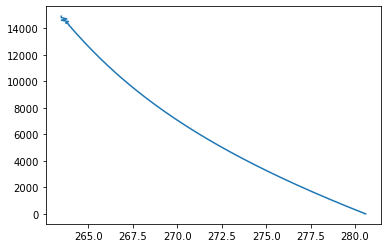

In [9]:
keep_prof,height=evolve()
Temp,up,down = keep_prof[-1]
plt.plot(Temp,height)